# Regularización - Dataset Sintético

Éste notebook es una continuación del ejercicio de la Clase 4 donde buscamos aproximar una función seno mediante regresiones polinómicas de distinto orden. En el mísmo, podíamos ver como, a partir de cierto orden, los modelos empezaban a hacer overfitting. Vamos a ver como usando técnicas de regularización podemos solucionarlo.

## Cargamos las librerías

In [15]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10


import warnings
warnings.filterwarnings("ignore")


## Generamos los datos

In [2]:
# Creamos los datos con NumPy. Pueden probar con diferentes funciones no lineales o incluso combinaciones de senos.
# Se puede probar también modificando el desvío estandar del ruido agregado.

# Generamos los 'x' de nuestra función no lineal a emplear
x = np.arange(60, 300, 4) # vector en grados
x = x*np.pi/180 # conversión a radianes
np.random.seed(10)

# Calculamos la función y agregamos ruido
stdv = 0.15
y = np.sin(x) + np.random.normal(0, stdv, len(x))

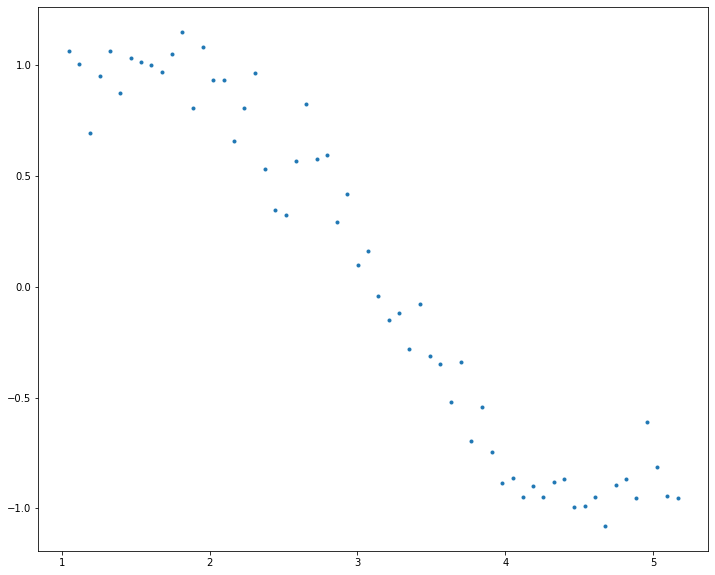

In [4]:
# convertimos los datos en un dataframe de pandas
plt.plot(x,y,'.')
plt.show()

## Creamos las features polinómicas

In [5]:
# Pueden crear las features polinómicas manualmente con NumPy empleando np.power o con SKlearn (PolynomialFeatures)
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(15, include_bias=False)
poly_data = poly.fit_transform(x.reshape(-1, 1))

In [6]:
# Creamos los column names para el dataframe (va a ser más fácil dar seguimiento luego)
colname = ['x']
for i in range(2, 16):
    colname.append('x_%d'%i)

colname.append('y')

In [7]:
# Creamos el dataframe
data = pd.DataFrame(np.column_stack([poly_data,y]),columns=colname)

In [8]:
data.head()

,x,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15,y
0,1.047198,1.096623,1.148381,1.202581,1.259340,1.318778,1.381021,1.446202,1.514459,1.585938,1.660790,1.739176,1.821260,1.907219,1.997235,1.065763
1,1.117011,1.247713,1.393709,1.556788,1.738948,1.942424,2.169709,2.423588,2.707173,3.023942,3.377775,3.773011,4.214494,4.707635,5.258479,1.006086
2,1.186824,1.408551,1.671702,1.984016,2.354677,2.794587,3.316683,3.936319,4.671717,5.544505,6.580351,7.809718,9.268760,11.000386,13.055521,0.695374
3,1.256637,1.579137,1.984402,2.493673,3.133642,3.937850,4.948448,6.218404,7.814277,9.819710,12.339811,15.506664,19.486248,24.487142,30.771450,0.949799
4,1.326450,1.759470,2.333850,3.095735,4.106339,5.446854,7.224981,9.583578,12.712139,16.862020,22.366630,29.668222,39.353420,52.200353,69.241170,1.063496


## Regresión Lineal

In [13]:
from sklearn.linear_model import LinearRegression

def linear_regression(data, power, models_to_plot):
    # Seleccionamos las features del dataframe data en función del argumento de entrada "power". Armamos una lista
    # con los features.
    predictors=['x']
    if power>=2:
        predictors.extend(['x_%d'%i for i in range(2,power+1)])
    
    # Hacemos el fit del modelo
    linreg = LinearRegression(normalize=True) # Importante normalizar
    linreg.fit(data[predictors],data['y'])
    y_pred = linreg.predict(data[predictors])
    
    # Se agregar una utilidad para graficar (ver fuente original) donde se indica los grados del polinomio 
    # a graficar (models_to_plot: diccionario con el orden del gráfico dentro del subplot)
    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for power: %d'%power)
    
    # Calculamos el ECM y devolvemos el mísmo junto con el intercept y el resto de los parámetros del modelo.
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

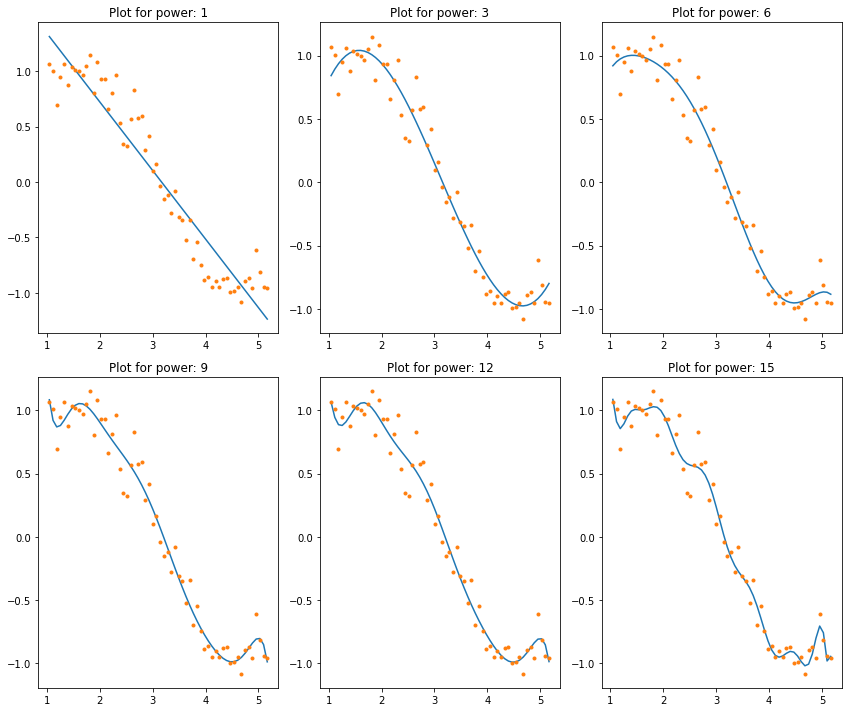

In [16]:
# Armamos los nombres de columna para el dataframe que almacena los parámetros
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
# Armamos indíces para el dataframe
ind = ['model_pow_%d'%i for i in range(1,16)]
# Creamos la estructura del dataframe
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1:231,3:232,6:233,9:234,12:235,15:236}

# Almacenamos en el dataframe los parámetros
for i in range(1,16):
    coef_matrix_simple.iloc[i-1,0:i+2] = linear_regression(data, power=i, models_to_plot=models_to_plot)

In [11]:
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
model_pow_1,3.3,2,-0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_2,3.3,1.9,-0.58,-0.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_3,1.1,-1.1,3,-1.3,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_4,1.1,-0.27,1.7,-0.53,-0.036,0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_5,1,3,-5.1,4.7,-1.9,0.33,-0.021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_6,0.99,-2.8,9.5,-9.7,5.2,-1.6,0.23,-0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_7,0.93,19,-56,69,-45,17,-3.5,0.4,-0.019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_8,0.92,43,-1.4e+02,1.8e+02,-1.3e+02,58,-15,2.4,-0.21,0.0077,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_9,0.87,1.7e+02,-6.1e+02,9.6e+02,-8.5e+02,4.6e+02,-1.6e+02,37,-5.2,0.42,-0.015,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_10,0.87,1.4e+02,-4.9e+02,7.3e+02,-6e+02,2.9e+02,-87,15,-0.81,-0.14,0.026,-0.0013,NaN,NaN,NaN,NaN,NaN


Observen la magnitud de los parámetros para los modelos de más alta complejidad (mayor orden del polinomio)

## Ridge

In [17]:
from sklearn.linear_model import Ridge

def ridge_regression(data, predictors, alpha, models_to_plot={}):
    # Hacemos el fit del modelo
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(data[predictors],data['y'])
    y_pred = ridgereg.predict(data[predictors])
    
    # Se agregar una utilidad para graficar (ver fuente original) donde se indica el alpha
    # a graficar (models_to_plot: diccionario con el orden del gráfico dentro del subplot)
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    # Calculamos el ECM y devolvemos el mísmo junto con el intercept y el resto de los parámetros del modelo.
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

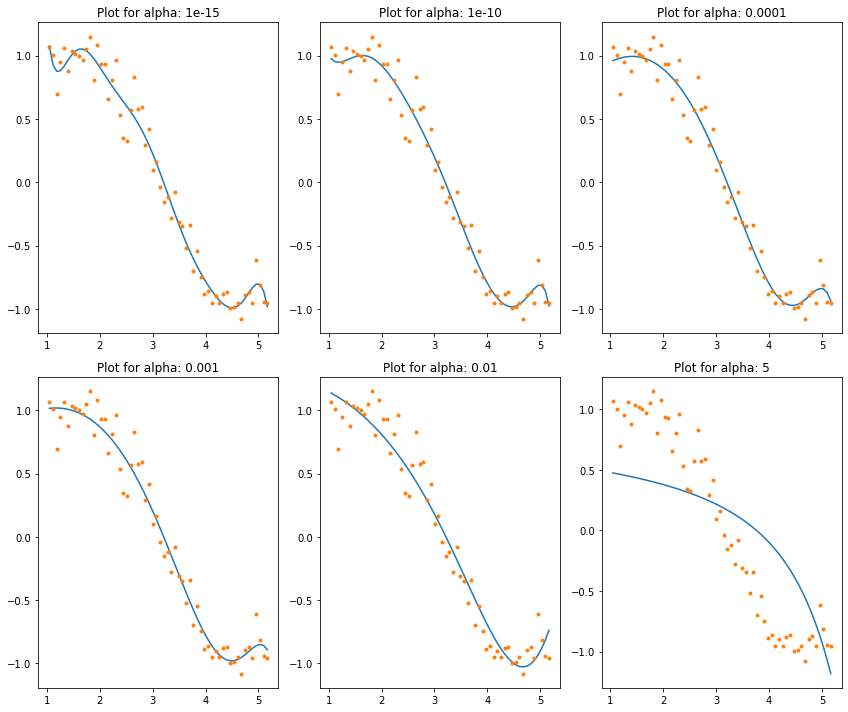

In [18]:
# Establecemos como features todas los órdenes del polinomio hasta el 15. Prueben con diferentes regresiones polinómicas para 
# ver el impacto en los coeficientes en función del alpha de regularización (lambda en la teoría)

predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)]) # Cambien el range para experimentar con diferentes polinomios

# Armamos un array con los distintos valores de lambda a probar
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

# Inicializamos el dataframe de parámetros como en el ejemplo anterior

col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 5:236}

for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(data, predictors, alpha_ridge[i], models_to_plot)

In [14]:
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_ridge

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,0.87,95,-3e+02,3.8e+02,-2.4e+02,70,-1.1,-4.2,0.55,0.14,-0.023,-0.0056,0.0009,0.00018,-4.5e-05,2.7e-06,-2.1e-08
alpha_1e-10,0.92,11,-29,31,-15,2.9,0.17,-0.091,-0.011,0.002,0.00064,2.4e-05,-2e-05,-4.2e-06,2.2e-07,2.3e-07,-2.3e-08
alpha_1e-08,0.95,1.3,-1.5,1.7,-0.68,0.039,0.016,0.00016,-0.00036,-5.4e-05,-2.9e-07,1.1e-06,1.9e-07,2e-08,3.9e-09,8.2e-10,-4.6e-10
alpha_0.0001,0.96,0.56,0.55,-0.13,-0.026,-0.0028,-0.00011,4.1e-05,1.5e-05,3.7e-06,7.4e-07,1.3e-07,1.9e-08,1.9e-09,-1.3e-10,-1.5e-10,-6.2e-11
alpha_0.001,1,0.82,0.31,-0.087,-0.02,-0.0028,-0.00022,1.8e-05,1.2e-05,3.4e-06,7.3e-07,1.3e-07,1.9e-08,1.7e-09,-1.5e-10,-1.4e-10,-5.2e-11
alpha_0.01,1.4,1.3,-0.088,-0.052,-0.01,-0.0014,-0.00013,7.2e-07,4.1e-06,1.3e-06,3e-07,5.6e-08,9e-09,1.1e-09,4.3e-11,-3.1e-11,-1.5e-11
alpha_1,5.6,0.97,-0.14,-0.019,-0.003,-0.00047,-7e-05,-9.9e-06,-1.3e-06,-1.4e-07,-9.3e-09,1.3e-09,7.8e-10,2.4e-10,6.2e-11,1.4e-11,3.2e-12
alpha_5,14,0.55,-0.059,-0.0085,-0.0014,-0.00024,-4.1e-05,-6.9e-06,-1.1e-06,-1.9e-07,-3.1e-08,-5.1e-09,-8.2e-10,-1.3e-10,-2e-11,-3e-12,-4.2e-13
alpha_10,18,0.4,-0.037,-0.0055,-0.00095,-0.00017,-3e-05,-5.2e-06,-9.2e-07,-1.6e-07,-2.9e-08,-5.1e-09,-9.1e-10,-1.6e-10,-2.9e-11,-5.1e-12,-9.1e-13
alpha_20,23,0.28,-0.022,-0.0034,-0.0006,-0.00011,-2e-05,-3.6e-06,-6.6e-07,-1.2e-07,-2.2e-08,-4e-09,-7.5e-10,-1.4e-10,-2.5e-11,-4.7e-12,-8.7e-13


Observen como para el polinomio de orden 15, donde en la regresión lineal ordinaria los parámetros eran elevados en magnitud, cuando usamos valores crecientes de alpha, el valor de los parámetros disminuye, tornándose cada vez más cercanos al cero. Para verificar la diferencia entre Ridge y LASSO, vemos en la siguiente tabla como ningún parámetro se vuelve realmente 0:

In [15]:
coef_matrix_ridge.apply(lambda x: sum(x.values==0),axis=1)

alpha_1e-15     0
alpha_1e-10     0
alpha_1e-08     0
alpha_0.0001    0
alpha_0.001     0
alpha_0.01      0
alpha_1         0
alpha_5         0
alpha_10        0
alpha_20        0
dtype: int64

## LASSO

In [19]:
from sklearn.linear_model import Lasso

def lasso_regression(data, predictors, alpha, models_to_plot={}):
    # Hacemos el fit del modelo
    lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5)
    lassoreg.fit(data[predictors],data['y'])
    y_pred = lassoreg.predict(data[predictors])
    
    # Se agregar una utilidad para graficar (ver fuente original) donde se indica el alpha
    # a graficar (models_to_plot: diccionario con el orden del gráfico dentro del subplot)
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    # Calculamos el ECM y devolvemos el mísmo junto con el intercept y el resto de los parámetros del modelo.
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

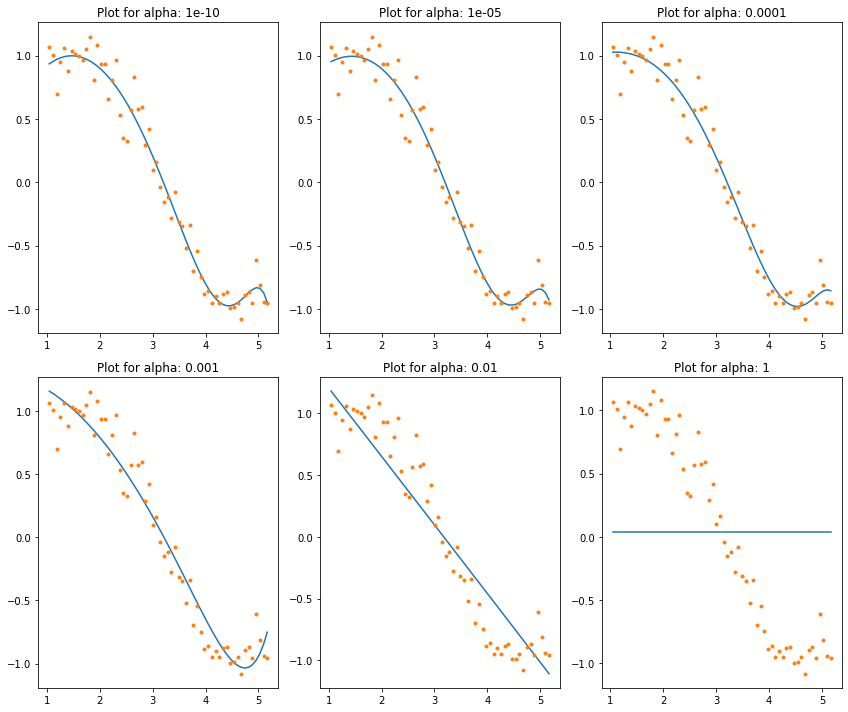

In [20]:
# Establecemos como features todas los órdenes del polinomio hasta el 15. Prueben con diferentes regresiones polinómicas para 
# ver el impacto en los coeficientes en función del alpha de regularización (lambda en la teoría)

predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)]) # Cambien el range para experimentar con diferentes polinomios

# Armamos un array con los distintos valores de lambda a probar
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

# Inicializamos el dataframe de parámetros como en el ejemplo anterior
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(0,10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1e-10:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 1:236}

for i in range(10):
    coef_matrix_lasso.iloc[i,] = lasso_regression(data, predictors, alpha_lasso[i], models_to_plot)

In [18]:
coef_matrix_lasso

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,0.96,0.22,1.1,-0.37,0.00089,0.0016,-0.00012,-6.4e-05,-6.3e-06,1.4e-06,7.8e-07,2.1e-07,4e-08,5.4e-09,1.8e-10,-2e-10,-9.2e-11
alpha_1e-10,0.96,0.22,1.1,-0.37,0.00088,0.0016,-0.00012,-6.4e-05,-6.3e-06,1.4e-06,7.8e-07,2.1e-07,4e-08,5.4e-09,1.8e-10,-2e-10,-9.2e-11
alpha_1e-08,0.96,0.22,1.1,-0.37,0.00077,0.0016,-0.00011,-6.4e-05,-6.3e-06,1.4e-06,7.8e-07,2.1e-07,4e-08,5.3e-09,2e-10,-1.9e-10,-9.3e-11
alpha_1e-05,0.96,0.5,0.6,-0.13,-0.038,-0,0,0,0,7.7e-06,1e-06,7.7e-08,0,0,0,-0,-7e-11
alpha_0.0001,1,0.9,0.17,-0,-0.048,-0,-0,0,0,9.5e-06,5.1e-07,0,0,0,-0,-0,-4.4e-11
alpha_0.001,1.7,1.3,-0,-0.13,-0,-0,-0,0,0,0,0,0,1.5e-08,7.5e-10,0,0,0
alpha_0.01,3.6,1.8,-0.55,-0.00056,-0,-0,-0,-0,-0,-0,-0,0,0,0,0,0,0
alpha_1,37,0.038,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_5,37,0.038,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_10,37,0.038,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0


Observen como a diferencia de la regresión con Ridge, en éste caso si se tienen parámetros nulos para los valores de alpha más elevados, lo cual es característico de la regularización LASSO. Se puede verificar más gráficamente con la siguiente tabla:

In [19]:
coef_matrix_lasso.apply(lambda x: sum(x.values==0),axis=1)

alpha_1e-15      0
alpha_1e-10      0
alpha_1e-08      0
alpha_1e-05      8
alpha_0.0001    10
alpha_0.001     12
alpha_0.01      13
alpha_1         15
alpha_5         15
alpha_10        15
dtype: int64

## Bibiliografía

* A visual explanation for regularization of linear models - Terence Parr
* A Complete Tutorial on Ridge and Lasso Regression in Python - Aarshay Jain